In [1]:
import pathlib

import zarr
import dask.array
import distributed
import astropy.units as u
from astropy.wcs.utils import wcs_to_celestial_frame, pixel_to_pixel
from astropy.visualization import ImageNormalize, AsymmetricPercentileInterval, LogStretch
import numpy as np
import matplotlib.pyplot as plt
import ndcube

from overlappy.util import strided_array, color_lat_lon_axes
from mocksipipeline.util import read_data_cube, stack_components
from mocksipipeline.detector.response import convolve_with_response, SpectrogramChannel

# Sampling and Remapping Simulated Counts

0. Set up Zarr store with one array per spectral order.
1. For a given spectral order, compute spectral cubes in instrument units; this will have dimensions (n_t, n_w, ny, nx)
2. Save each timestep to Zarr
3. Concatenate all timesteps into a single Dask array
4. Compute Poisson statistics on Dask array
4. Sum along time dimension
5. Remap non-zero counts to detector array to create overlappogram

In [2]:
def instr_cube_to_zarr(time_index, zarr_store, spec_cube_dir, channel):
    spec_cube = read_data_cube(spec_cube_dir / f'spec_cube_t{time_index}.fits')
    instr_cube = convolve_with_response(spec_cube, channel, electrons=False)
    root = zarr.open(zarr_store, mode='a')
    root[f'instr_cube_{channel.spectral_order}'][time_index, ...] = instr_cube.data

In [3]:
def sample_spectral_cube(zarr_store, channel, instr_cube_wcs, observer):
    """
    Sample a Poisson distribution based on counts from spectral cube and map counts to detector pixels.
    """
    root = zarr.open(zarr_store, mode='r')
    lam = dask.array.from_zarr(root[f'instr_cube_{channel.spectral_order}'])
    samples = dask.array.random.poisson(lam=lam, size=lam.shape).sum(axis=0)
    idx_nonzero = dask.array.where(samples>0)
    idx_nonzero = [i.compute() for i in idx_nonzero]
    weights = samples[samples>0].compute()
    # Map counts to detector coordinates
    overlap_wcs = channel.get_wcs(observer)
    idx_nonzero_overlap = pixel_to_pixel(instr_cube_wcs, overlap_wcs, *idx_nonzero[::-1])
    n_rows = channel.detector_shape[0]//2
    n_cols = channel.detector_shape[1]
    hist, _, _ = np.histogram2d(idx_nonzero_overlap[1], idx_nonzero_overlap[0],
                                bins=(n_rows, n_cols),
                                range=([-.5, n_rows-.5], [-.5, n_cols-.5]),
                                weights=weights)
    return ndcube.NDCube(strided_array(hist, channel.wavelength.shape[0],),
                         wcs=overlap_wcs,
                         unit='photon')

In [4]:
hf_results = pathlib.Path('../data/simulations/') / 'high_frequency'
hf_spec_cube_dir = hf_results / 'spectral'

In [5]:
spec_cube = read_data_cube(hf_spec_cube_dir / 'spec_cube_t0.fits')
observer = wcs_to_celestial_frame(spec_cube.wcs).observer

In [6]:
channels = [SpectrogramChannel(order) for order in range(5)]

In [7]:
spec_cube_files = list(hf_spec_cube_dir.glob('spec_cube_t*.fits'))
n_time = len(spec_cube_files)

In [8]:
client = distributed.Client(address='tcp://127.0.0.1:52002')

In [9]:
zarr_store = hf_results / 'instr_cubes.zarr'
root = zarr.open(zarr_store, mode='a')
overlappograms = {}
for channel in channels:
    # NOTE: precomputing one instrument cube here to get the WCS and needed dimensions
    tmp_cube = convolve_with_response(read_data_cube(spec_cube_files[0],), channel, electrons=False,)
    instr_cube_wcs = tmp_cube.wcs
    shape = (n_time,) + tmp_cube.data.shape
    ds = root.create_dataset(f'instr_cube_{channel.spectral_order}',
                             shape=shape,
                             chunks=(1,)+tmp_cube.data.shape,
                             overwrite=True)
    for i in range(n_time):
        instr_cube_to_zarr(i, zarr_store, hf_spec_cube_dir, channel)
    overlappograms[channel.spectral_order] = sample_spectral_cube(zarr_store, channel, instr_cube_wcs, observer)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *ar

In [11]:
total_overlappogram = stack_components([v for k,v in overlappograms.items()], wcs_index=0)

In [16]:
def get_norm_from_percentile(data, lower_percentile=1, upper_percentile=99, unit=None, stretch=LogStretch()):
    interval = AsymmetricPercentileInterval(lower_percentile, upper_percentile)
    if unit is None:
        unit = data.unit
    vmin,vmax = interval.get_limits(data.to_value(unit))
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)
    return norm

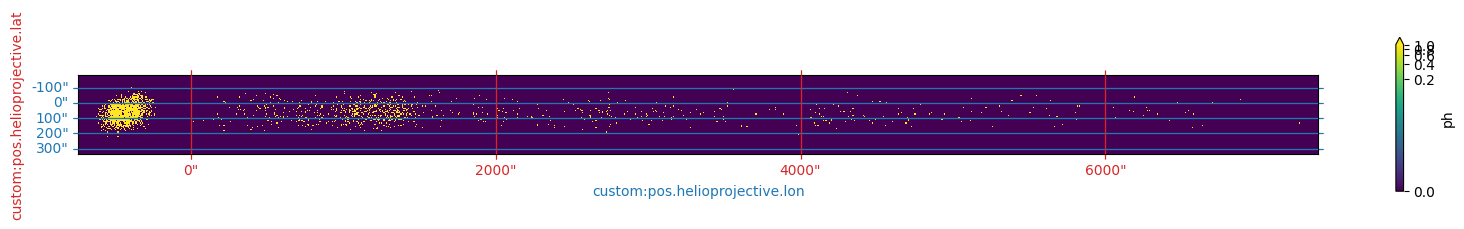

In [42]:
data_unit = u.Unit('photon')

fig = plt.figure(figsize=(20,2))
cropped_cube = total_overlappogram[0,330:400,900:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
    interpolation='none',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

## Sandbox

In [21]:
spec_cube = read_data_cube(spec_cube_files[0])

In [22]:
def sample_spectral_cube(spec_cube, order, dt=1*u.s, interval=20*u.s):
    """
    Sample a Poisson distribution based on counts from spectral cube and map counts to detector pixels.
    """
    # Convert to instrument units
    observer = wcs_to_celestial_frame(spec_cube.wcs).observer
    chan = SpectrogramChannel(order)
    instr_cube = convolve_with_response(spec_cube, chan, electrons=False)
    # Sample distribution
    lam = (instr_cube.data * instr_cube.unit * u.pix * dt).to_value('photon')
    # NOTE: this should not be needed in general...
    lam = np.where(lam<0, 0, lam)
    lam = dask.array.from_array(lam, chunks='auto')
    num_iterations = int(np.ceil((interval / dt).decompose()))
    samples = dask.array.random.poisson(lam=lam, size=(num_iterations,)+lam.shape).sum(axis=0)
    samples = samples.compute()
    idx_nonzero = np.where(samples>0)
    # Map counts to detector coordinates
    overlap_wcs = chan.get_wcs(observer)
    idx_nonzero_overlap = pixel_to_pixel(instr_cube.wcs, overlap_wcs, *idx_nonzero[::-1])
    n_rows = chan.detector_shape[0]//2
    n_cols = chan.detector_shape[1]
    hist, _, _ = np.histogram2d(idx_nonzero_overlap[1], idx_nonzero_overlap[0],
                                bins=(n_rows, n_cols),
                                range=([-.5, n_rows-.5], [-.5, n_cols-.5]),
                                weights=samples[idx_nonzero])
    return ndcube.NDCube(strided_array(hist, chan.wavelength.shape[0],),
                         wcs=overlap_wcs,
                         unit='photon')

In [31]:
test_overlaps = [
    sample_spectral_cube(spec_cube, 0, interval=1*u.h),
    sample_spectral_cube(spec_cube, 1, interval=1*u.h),
    sample_spectral_cube(spec_cube, 2, interval=1*u.h),
    sample_spectral_cube(spec_cube, 3, interval=1*u.h),
    sample_spectral_cube(spec_cube, 4, interval=1*u.h),
]
test_total_overlap = stack_components(test_overlaps, wcs_index=0)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result =

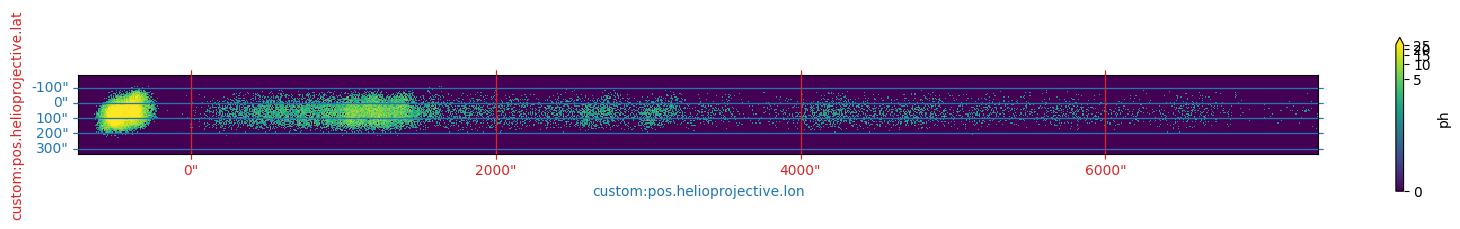

In [43]:
data_unit = u.Unit('photon')

fig = plt.figure(figsize=(20,2))
cropped_cube = test_total_overlap[0,330:400,900:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
    interpolation='none'
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

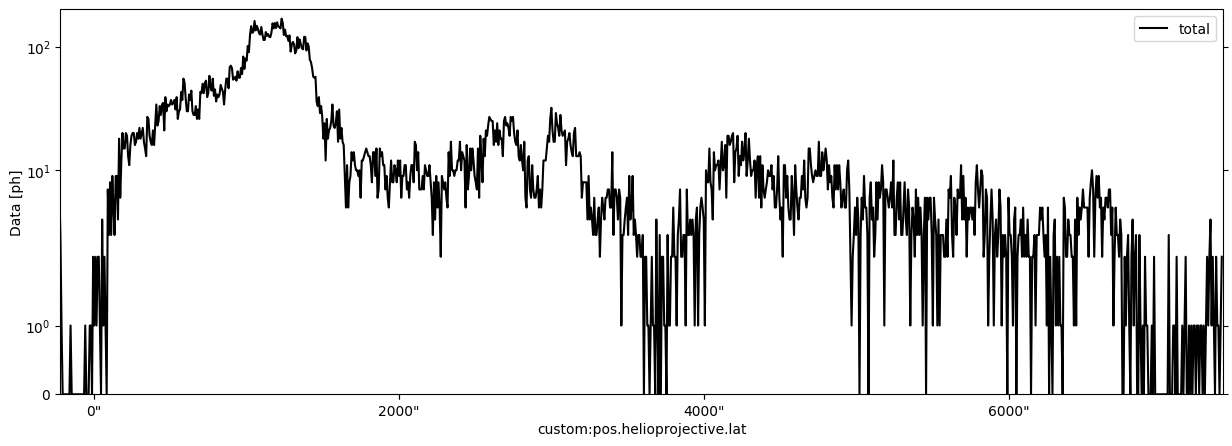

In [69]:
data_unit = 'ph'
fig = plt.figure(figsize=(15,5))
total_rebin = test_total_overlap[0].rebin((test_total_overlap[0].data.shape[0], 1),operation=np.sum)[0]
ax = fig.add_subplot(projection=total_rebin)
#for order,component in enumerate(test_overlaps):
#    component[0].rebin((component[0].data.shape[0], 1),operation=np.sum)[0].plot(axes=ax, label=f'order={order}', data_unit=data_unit)
total_rebin.plot(axes=ax, color='k', ls='-', label='total', data_unit=data_unit)
#ax.axhline(y=1, color='k', ls=':')
ax.set_yscale('symlog')
ax.set_ylim(0, 200)
ax.set_xlim(970,2000)
ax.legend(ncol=3)

In [57]:
from overlappy.io import read_overlappogram

In [58]:
obs_overlap_components = [
    read_overlappogram('../data/observations/overlappograms_full_disk/overlappogram-order-3.fits'),
    read_overlappogram('../data/observations/overlappograms_full_disk/overlappogram-order-2.fits'),
    read_overlappogram('../data/observations/overlappograms_full_disk/overlappogram-order-1.fits'),
    read_overlappogram('../data/observations/overlappograms_full_disk/overlappogram-order0.fits'),
    read_overlappogram('../data/observations/overlappograms_full_disk/overlappogram-order1.fits'),
    read_overlappogram('../data/observations/overlappograms_full_disk/overlappogram-order2.fits'),
    read_overlappogram('../data/observations/overlappograms_full_disk/overlappogram-order3.fits'),
]

In [59]:
obs_overlap_total = stack_components(obs_overlap_components, wcs_index=3)

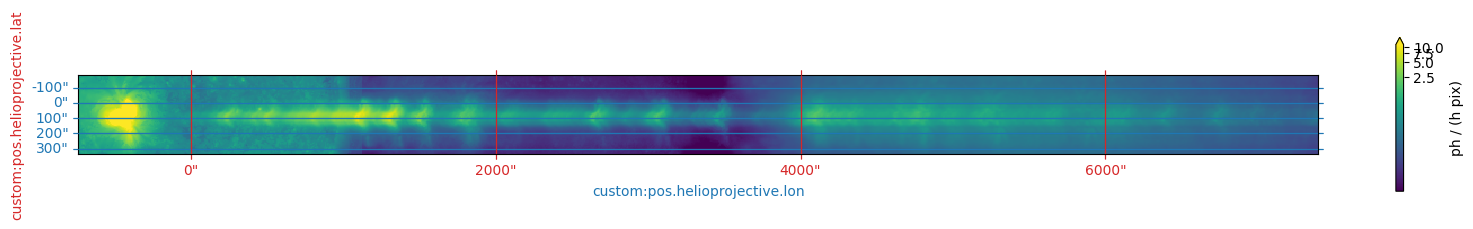

In [62]:
data_unit = u.Unit('photon/pix/h')

fig = plt.figure(figsize=(20,2))
cropped_cube = obs_overlap_total[0,330:400,900:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
    interpolation='none'
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

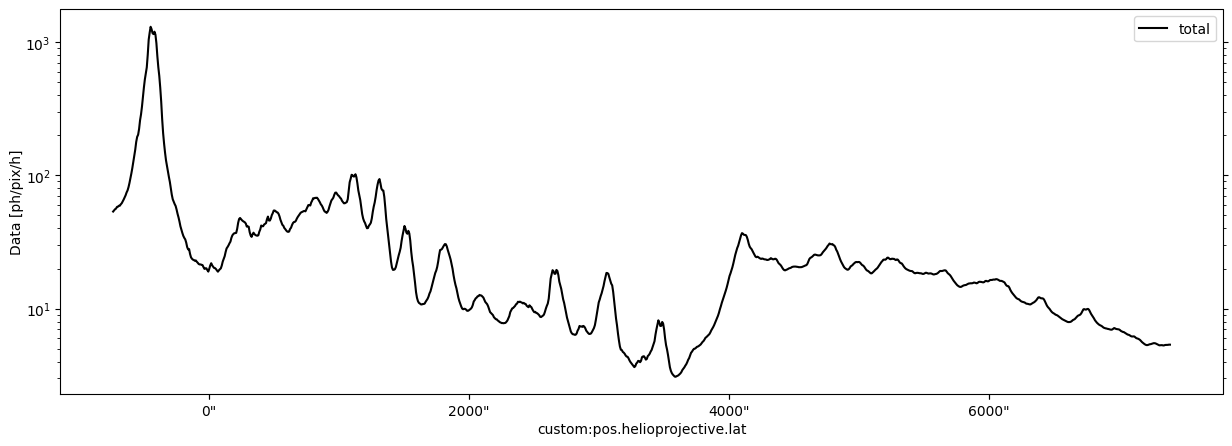

In [64]:
data_unit = 'ph/pix/h'
fig = plt.figure(figsize=(15,5))
total_rebin = obs_overlap_total[0,330:400,900:].rebin((obs_overlap_total[0,330:400,900:].data.shape[0], 1),operation=np.sum)[0]
ax = fig.add_subplot(projection=total_rebin)
#for order,component in enumerate(test_overlaps):
#    component[0].rebin((component[0].data.shape[0], 1),operation=np.sum)[0].plot(axes=ax, label=f'order={order}', data_unit=data_unit)
total_rebin.plot(axes=ax, color='k', ls='-', label='total', data_unit=data_unit)
#ax.axhline(y=1, color='k', ls=':')
ax.set_yscale('log')
#ax.set_ylim(1, 200)
#ax.set_xlim(970,2000)
ax.legend(ncol=3)

In [2]:
from overlappy.io import read_overlappogram

In [16]:
#test_overlaps = [read_overlappogram(f) for f in sorted(list(pathlib.Path('../pipeline/data/p0.3/overlappograms/').glob('*.fits')))]
#test_total_overlap = stack_components(test_overlaps)
test_total_overlap = read_overlappogram('../pipeline/data/p0.3/overlappograms/overlappogram_o2.fits')

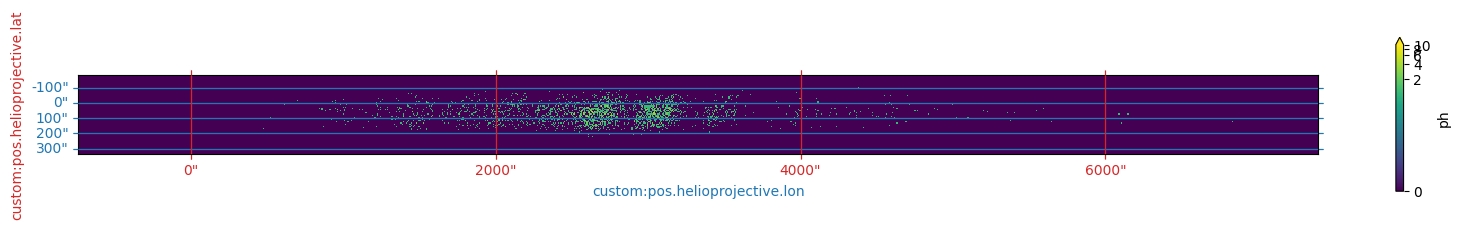

In [17]:
data_unit = u.Unit('photon')

fig = plt.figure(figsize=(20,2))
cropped_cube = test_total_overlap[0,330:400,900:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=ImageNormalize(vmin=0, vmax=10, stretch=LogStretch()),
    data_unit=data_unit,
    cmap='viridis',
    interpolation='none'
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

In [129]:
overlaps = [
    stack_components([read_overlappogram(f) for f in pathlib.Path('../pipeline/data/p0.3/overlappograms/').glob('overlappogram_o*.fits')]),
    #stack_components([read_overlappogram(f) for f in pathlib.Path('../pipeline/data/p0.05/overlappograms/').glob('overlappogram_o*.fits')]),
    stack_components([read_overlappogram(f) for f in pathlib.Path('../pipeline/data/p0.005/overlappograms/').glob('overlappogram_o*.fits')]),
]

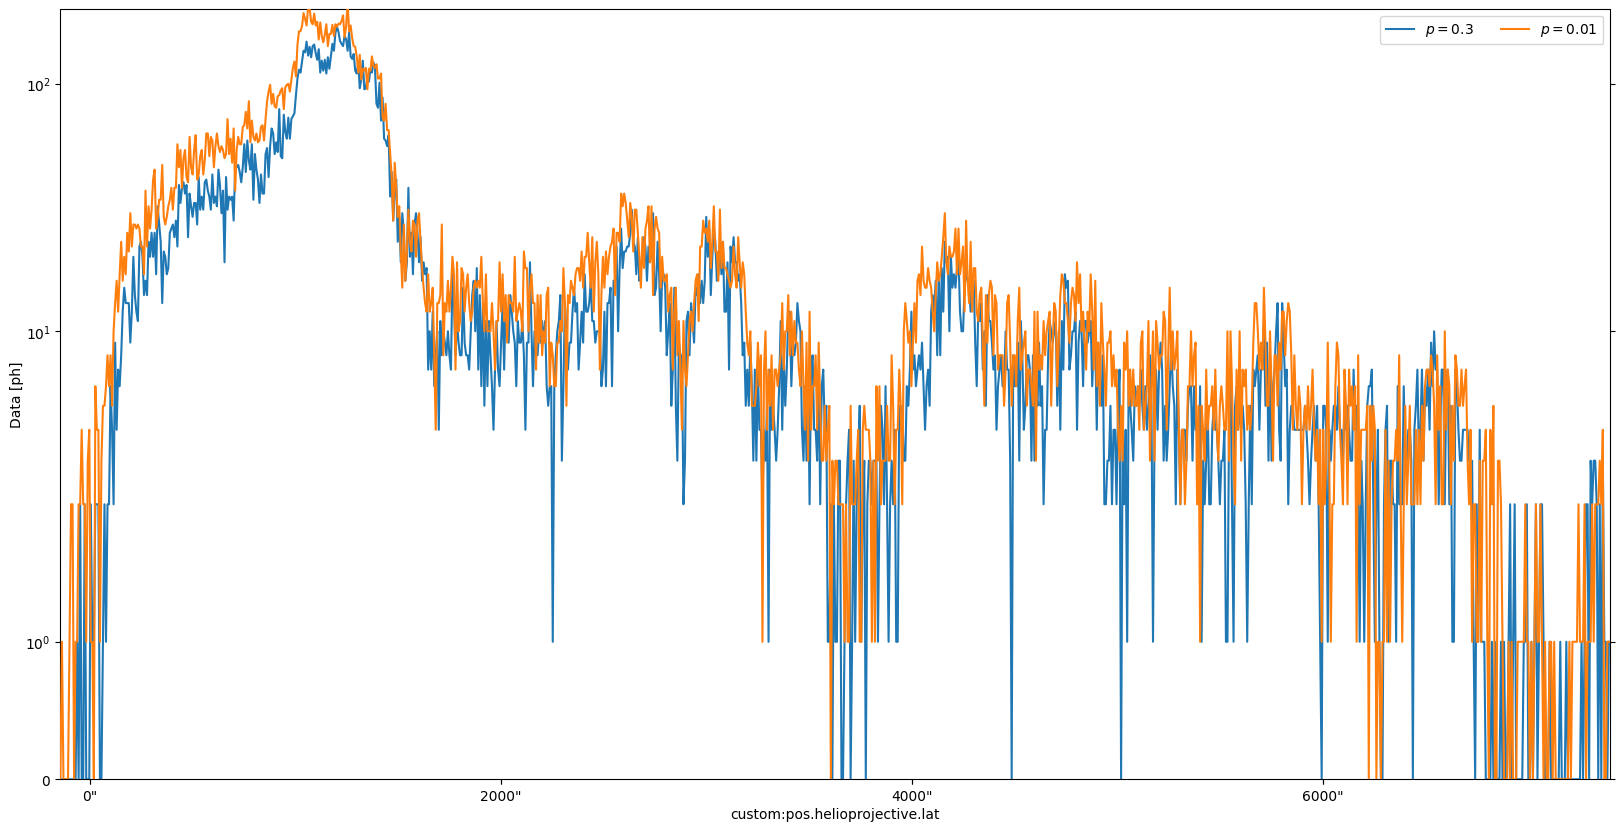

In [130]:
data_unit = 'ph'
fig = plt.figure(figsize=(20,10))
ax = None
for ol,lab in zip(overlaps,[0.3, 0.01]):
    total_rebin = ol[0].rebin((ol[0].data.shape[0], 1),operation=np.sum)[0]
    if ax is None:
        ax = fig.add_subplot(projection=total_rebin)
    total_rebin.plot(axes=ax, ls='-', data_unit=data_unit, label=f'$p={lab}$')
ax.set_yscale('symlog')
ax.set_ylim(0, 200)
ax.set_xlim(980,2000)
ax.legend(ncol=3)

In [37]:
import synthesizAR

In [45]:
skeletons = [
    synthesizAR.Skeleton.from_asdf('../pipeline/data/p0.3/skeleton.asdf'),
    synthesizAR.Skeleton.from_asdf('../pipeline/data/p0.05/skeleton.asdf'),
    synthesizAR.Skeleton.from_asdf('../pipeline/data/p0.01/skeleton.asdf'),
]

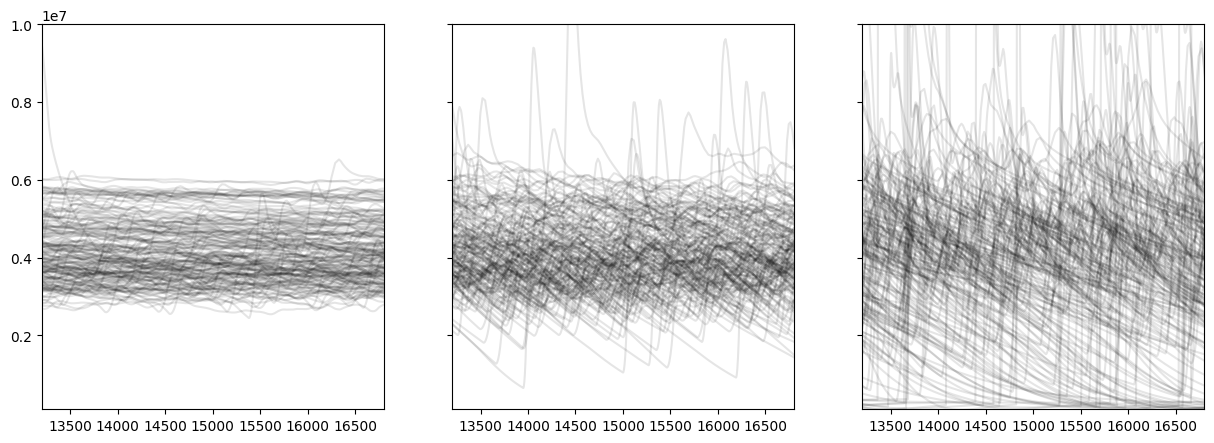

In [66]:
l_index = 5
fig,ax = plt.subplots(1,len(skeletons),sharex=True,sharey=True,figsize=(15,5))
for i,s in enumerate(skeletons):
    for l in s.loops[::5]:
        ax[i].plot(l.time, l.electron_temperature[:,0], color='k', alpha=0.1)
    ax[i].set_xlim(1.5e4+np.array([-3600, 3600])/2)
    ax[i].set_ylim(1e5,1e7)

In [97]:
import sys
sys.path.append('../scripts')
from instruments import InstrumentDEMOXSI

import sunpy.map

In [135]:
time_index = 0
t_bin_edges = 10**np.arange(5.5,7.6,0.1)*u.K
t_bin_centers = 10**((np.log10(t_bin_edges.value)[:-1] + np.log10(t_bin_edges.value)[1:])/2)*u.K
dem_cubes = []
p_vals = [0.3,0.05, 0.01, 0.005]
for p in p_vals:
    dem_output_dir = pathlib.Path(f'../pipeline/data/p{p}/dem/')
    dem_maps = sunpy.map.Map(sorted(list(dem_output_dir.glob(f'*_t{time_index}.fits'))))
    dem_cubes.append(InstrumentDEMOXSI.dem_maps_list_to_cube(dem_maps, t_bin_centers))

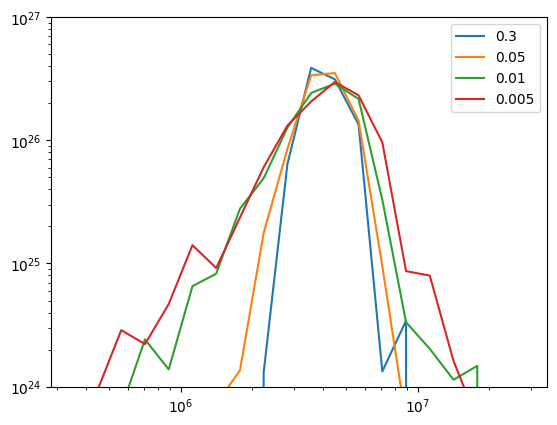

In [136]:
for dc,p in zip(dem_cubes,p_vals):
    plt.plot(t_bin_centers,dc.rebin((1,)+dc[0].data.shape, operation=np.mean).data.squeeze(),label=p)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e24,1e27)
plt.legend()

In [116]:
import fiasco

In [118]:
o7 = fiasco.Ion("O VII",t_bin_centers)
o8 = fiasco.Ion("O VIII",t_bin_centers)

In [120]:
o7.formation_temperature

<Quantity 891250.93813374 K>